In [1]:
import numpy as np
import pandas as pd

df=pd.read_csv('/Users/fabianlaw/code/fablaw/circor/raw_data/1.0.3/new_table_3.csv')
df

,Unnamed: 0,Patient_id,select,audible,target
0,0,2530,TV,TV,Absent
1,1,9979,TV,TV,Present
2,3,13918,TV,TV,Present
3,4,14241,PV,PV,Present
4,5,14998,PV,PV,Absent
...,...,...,...,...,...
807,937,85340,MV,MV,Absent
808,938,85341,MV,MV,Absent
809,939,85343,AV,TV,Present
810,940,85345,PV,PV,Absent


In [2]:
df[df.Patient_id == 85165].index.values

array([720])

In [3]:
df.loc[720, 'audible']='AV'

In [4]:
X_raw=[]
for i in df.index:
    file='../raw_data/1.0.3/proc_img_2/'+str(df.loc[i,'Patient_id'])+'_'+df.loc[i,'audible']+'.npy'
    v=np.load(file)
    X_raw.append(v)
    
X=np.stack(X_raw)

In [5]:
y=df.target.map({'Present': 1, 'Absent': 0})
y.shape

(812,)

In [6]:
X.shape

(812, 224, 224, 3)

In [7]:
y

0      0
1      1
2      1
3      1
4      0
      ..
807    0
808    0
809    1
810    0
811    0
Name: target, Length: 812, dtype: int64

In [8]:
from sklearn.utils import class_weight
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test=train_test_split(X, y, test_size=0.3, random_state=1)
class_weights = class_weight.compute_class_weight(class_weight='balanced',
                                                  classes=np.unique(y_train),
                                                  y=y_train)

In [9]:
class_weights

array([0.61471861, 2.67924528])

In [10]:
cl={0: class_weights[0], 1: class_weights[1]}

In [11]:
from tensorflow.keras.layers import Dense, Flatten, MaxPooling2D, Conv2D, LSTM, BatchNormalization
from tensorflow.keras import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.applications.resnet import ResNet101
from tensorflow.keras.metrics import Recall

import matplotlib.pyplot as plt

In [12]:
base_model = ResNet101(include_top=False, input_shape=(224, 224, 3))

In [13]:
base_model.trainable = False

In [16]:
layer1=Conv2D(32, kernel_size=(3,3), activation='relu')
layer2=BatchNormalization(gamma_initializer='ones', beta_initializer='zeros', moving_mean_)
layer3=Dense(1, activation='sigmoid')

In [17]:
model = Sequential([base_model, layer1, layer2, layer3])

In [18]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet101 (Functional)      (None, 7, 7, 2048)        42658176  
                                                                 
 flatten (Flatten)           (None, 100352)            0         
                                                                 
 dense (Dense)               (None, 1024)              102761472 
                                                                 
 dense_1 (Dense)             (None, 1)                 1025      
                                                                 
Total params: 145,420,673
Trainable params: 102,762,497
Non-trainable params: 42,658,176
_________________________________________________________________


In [19]:
model.compile(loss=BinaryCrossentropy(),
              optimizer=Adam(learning_rate=0.0001),
              metrics=['accuracy', Recall()])

In [24]:
es=EarlyStopping(patience=10, restore_best_weights=True, monitor='val_recall')
history=model.fit(X_train, y_train, 
                  validation_split=0.2, 
                  batch_size=32, 
                  epochs=150, 
                  callbacks=[es], 
                  class_weight=cl)

/Users/fabianlaw/.pyenv/versions/3.10.6/envs/circor/lib/python3.10/site-packages/keras/engine/data_adapter.py:1699: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  return t[start:end]


Epoch 1/150


2022-12-01 22:07:09.916482: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


15/15 [==============================] - 39s 2s/step - loss: 1.7884 - accuracy: 0.4912 - recall: 0.4598 - val_loss: 0.6830 - val_accuracy: 0.8246 - val_recall: 0.1579
Epoch 2/150
15/15 [==============================] - 38s 3s/step - loss: 0.7551 - accuracy: 0.4053 - recall: 0.5977 - val_loss: 0.6219 - val_accuracy: 0.8333 - val_recall: 0.0000e+00
Epoch 3/150
15/15 [==============================] - 39s 3s/step - loss: 0.7407 - accuracy: 0.5044 - recall: 0.4943 - val_loss: 0.4790 - val_accuracy: 0.8333 - val_recall: 0.0000e+00
Epoch 4/150
15/15 [==============================] - 40s 3s/step - loss: 0.8383 - accuracy: 0.4736 - recall: 0.4138 - val_loss: 0.4506 - val_accuracy: 0.8333 - val_recall: 0.0000e+00
Epoch 5/150
15/15 [==============================] - 41s 3s/step - loss: 0.7799 - accuracy: 0.5044 - recall: 0.4368 - val_loss: 1.0125 - val_accuracy: 0.1667 - val_recall: 1.0000
Epoch 6/150
15/15 [==============================] - 41s 3s/step - loss: 0.7355 - accuracy: 0.5683 - reca

In [25]:
def plot_loss_recall(history):
    fig, (ax1, ax2) = plt.subplots(1,2, figsize=(13,4))
    ax1.plot(history.history['loss'])
    ax1.plot(history.history['val_loss'])
    ax1.set_title('Model loss')
    ax1.set_ylabel('Loss')
    ax1.set_xlabel('Epoch')
    ax1.set_ylim(ymin=0, ymax=1)
    ax1.legend(['Train', 'Validation'], loc='best')
    ax1.grid(axis="x",linewidth=0.5)
    ax1.grid(axis="y",linewidth=0.5)    

    
    ax2.plot(history.history['recall'])
    ax2.plot(history.history['val_recall'])
    ax2.set_title('RECALL')
    ax2.set_ylabel('Recall')
    ax2.set_xlabel('Epoch')
    ax2.set_ylim(ymin=0, ymax=2)
    ax2.legend(['Train', 'Validation'], loc='best')
    ax2.grid(axis="x",linewidth=0.5)
    ax2.grid(axis="y",linewidth=0.5)    

    plt.show()

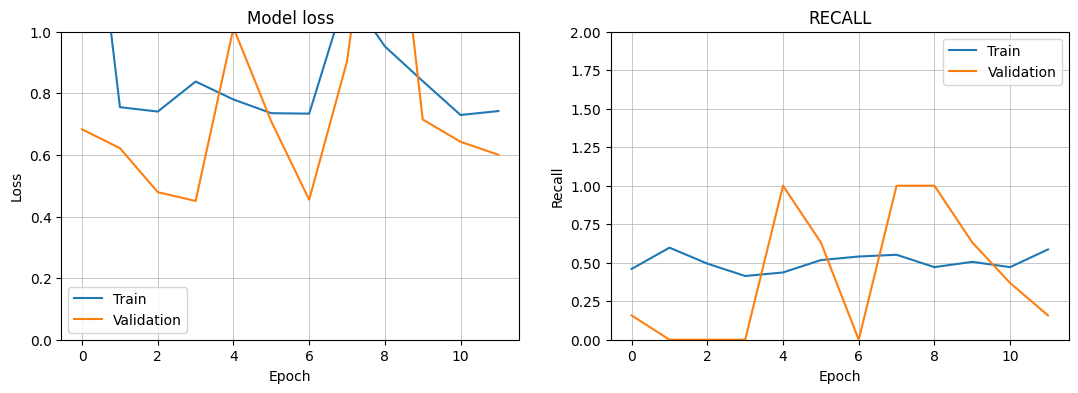

In [26]:
plot_loss_recall(history)